# Classification. Linear models and KNN

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## Part 2: Porto Seguro’s Safe Driver Prediction

In [ ]:
#PATH = "./data/"

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join('train.csv')).set_index('id')#os.path.join(PATH, 'porto', 'train.csv')

In [ ]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

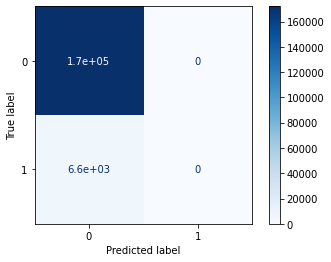

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

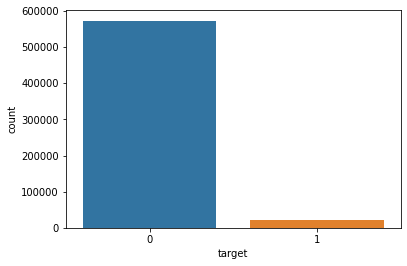

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** (2) :

Параметрическое уравнение для ROC curve можно записать в следующем виде:

$$AUC = \int_{0}^{1} TPR \enspace dFPR = \int_{0}^{1} \frac{TP}{n_1} \enspace d\frac{FP}{n_0} = \frac{1}{n_1*n_0}\int_{0}^{1}TP \enspace dFP \hspace{35pt} $$(3)

При построении графика Lift Curve по оси  мы откладывали долю объектов (их количество) предварительно отсортированных по убыванию. Таким образом, параметрическое уравнение для Коэффициента Джини будет выглядеть следующим образом:

$$AUC = \int_{0}^{1} TPR \enspace d\frac{TP + FP}{n_1+n_0} - 0.5  $$(4)

Подставив выражение (4) в выражение $$Gini_{normalized} = \frac{Gini_{model}}{Gini_{perfect}} $$ для обеих моделей и преобразовав его, мы увидим, что в одну из частей можно будет подставить выражение (3), что в итоге даст нам красивую формулу нормализованного Джини (2).

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

- Матрица ошибок (англ. Сonfusion matrix)
- Точность (англ. Precision)
- Полнота (англ. Recall)
- F-мера (англ. F-score)
- Precison-recall кривая
- Сбалансированная точность (Balanced Accuracy)
- Энтропия

Let's calculate the Normalized Gini Coefficient:

**(1.5 points + X bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
X bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
insurance_data = pd.read_csv(os.path.join('train.csv')).set_index('id')#os.path.join(PATH, 'porto', 'train.csv')
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
insurance_data2 = pd.read_csv(os.path.join('test.csv')).set_index('id')#os.path.join(PATH, 'porto', 'test.csv')
insurance_data2.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  8,      10,      11,
            ...
            1488014, 1488015, 1488018, 1488019, 1488020, 1488022, 1488023,
            1488024, 1488025, 1488026],
           dtype='int64', name='id', length=892816)

In [ ]:
data= X.append(insurance_data2)

In [ ]:
da = preprocessor.fit(data)

In [ ]:
data.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,1.901574e+00,1.358745e+00,4.417567e+00,4.171346e-01,4.069547e-01,3.934442e-01,2.571276e-01,1.637637e-01,1.856645e-01,3.729769e-04,1.633706e-03,9.401033e-03,1.002669e-03,1.241038e-02,7.298086e+00,6.606838e-01,1.206718e-01,1.543620e-01,6.110305e-01,4.395943e-01,5.514848e-01,8.293596e+00,8.299367e-01,-5.048964e-01,7.255556e-01,-1.581623e-01,6.560714e+00,9.100971e-01,8.322189e-01,1.328302e+00,9.921346e-01,6.225685e+01,2.346392e+00,3.799519e-01,8.134878e-01,2.763614e-01,3.067355e+00,4.496817e-01,4.501073e-01,4.499718e-01,2.371666e+00,1.885551e+00,7.688461e+00,3.008052e+00,9.225874e+00,2.338736e+00,8.439336e+00,5.439640e+00,1.440927e+00,2.873923e+00,7.539831e+00,1.232027e-01,6.277899e-01,5.544687e-01,2.875504e-01,3.492159e-01,1.527841e-01
std,1.985417e+00,6.636391e-01,2.700054e+00,4.933963e-01,1.353300e+00,4.885141e-01,4.370505e-01,3.700612e-01,3.888358e-01,1.930901e-02,4.038611e-02,9.650212e-02,3.164909e-02,1.273684e-01,3.543585e+00,4.734774e-01,3.257456e-01,3.612955e-01,2.876763e-01,4.045123e-01,7.938159e-01,2.508307e+00,3.757064e-01,7.887134e-01,2.154316e+00,8.445060e-01,5.500869e+00,3.472121e-01,3.736719e-01,9.787431e-01,9.156538e-02,3.300722e+01,8.320187e-01,5.836187e-02,2.247024e-01,3.569623e-01,7.299510e-01,2.872071e-01,2.871817e-01,2.872136e-01,1.117059e+00,1.136029e+00,1.333837e+00,1.414919e+00,1.460205e+00,1.247940e+00,2.905658e+00,2.331197e+00,1.201557e+00,1.694398e+00,2.746189e+00,3.286698e-01,4.833941e-01,4.970245e-01,4.526205e-01,4.767225e-01,3.597794e-01
min,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,2.506191e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-01,2.000000e-01,5.250000e-01,7.000000e+

In [ ]:
data.isnull().mean()

ps_ind_01         0.0
ps_ind_02_cat     0.0
ps_ind_03         0.0
ps_ind_04_cat     0.0
ps_ind_05_cat     0.0
ps_ind_06_bin     0.0
ps_ind_07_bin     0.0
ps_ind_08_bin     0.0
ps_ind_09_bin     0.0
ps_ind_10_bin     0.0
ps_ind_11_bin     0.0
ps_ind_12_bin     0.0
ps_ind_13_bin     0.0
ps_ind_14         0.0
ps_ind_15         0.0
ps_ind_16_bin     0.0
ps_ind_17_bin     0.0
ps_ind_18_bin     0.0
ps_reg_01         0.0
ps_reg_02         0.0
ps_reg_03         0.0
ps_car_01_cat     0.0
ps_car_02_cat     0.0
ps_car_03_cat     0.0
ps_car_04_cat     0.0
ps_car_05_cat     0.0
ps_car_06_cat     0.0
ps_car_07_cat     0.0
ps_car_08_cat     0.0
ps_car_09_cat     0.0
ps_car_10_cat     0.0
ps_car_11_cat     0.0
ps_car_11         0.0
ps_car_12         0.0
ps_car_13         0.0
ps_car_14         0.0
ps_car_15         0.0
ps_calc_01        0.0
ps_calc_02        0.0
ps_calc_03        0.0
ps_calc_04        0.0
ps_calc_05        0.0
ps_calc_06        0.0
ps_calc_07        0.0
ps_calc_08        0.0
ps_calc_09

In [ ]:
import warnings
warnings.filterwarnings('ignore') 
#ignoring warnings from gridsearch, cause some of solvers dont have one of penalties

lr_param_grid = {'max_iter' : [500, 1000]
                    #'solver' : ['lbfgs']
                                       }


lr_clf = GridSearchCV(LogisticRegression(random_state=42, n_jobs=4), lr_param_grid)

In [ ]:
lr_best_clf= lr_clf.fit(da.transform(data.iloc[X.index]), y)
y_predl = clf.predict_proba(insurance_data2)

In [ ]:
lr_best_clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=4, penalty='l2', random_state=42,
                    solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': 4,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'max_iter': [500, 1000]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [ ]:
ansl = pd.DataFrame(y_predl[:,1], index= insurance_data2.index)
ansl.columns = ['target']
ansl.to_csv('ansl.csv', sep=',')

In [ ]:
knn_param_grid = {'n_neighbors': [100, 50, 30, 10]#, 'weights': ['uniform', 'distance'],
                    
                   }

knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=2), knn_param_grid)

In [ ]:
knn_best_clf= knn_clf.fit(da.transform(data.iloc[X.index]), y)

In [ ]:
y_predk = knn_best_clf.predict_proba(da.transform(data.iloc[insurance_data2.index]))

In [ ]:
knn_best_clf.get_params()

In [ ]:
ansk = pd.DataFrame(y_predk[:,1], index= insurance_data2.index)
ansk.columns = ['target']
ansk.to_csv('ansk.csv', sep=',')

Best result:

In [50]:
model = LogisticRegression(max_iter=2000)

In [51]:
pipelr = Pipeline(steps=[('preprocessor', preprocessor),
           ('classifier', model)]).fit(X, y)

y_predlr = pipelr.predict_proba(insurance_data2)

In [52]:
anslr = pd.DataFrame(y_predlr[:,1], index= insurance_data2.index)
anslr.columns = ['target']
anslr.to_csv('anslr.csv', sep=',')

In [53]:
print('My result: 1.5 points +',round(200*(0.25962-0.253))/2, 'bonus points')

My result: 1.5 points + 0.5 bonus points


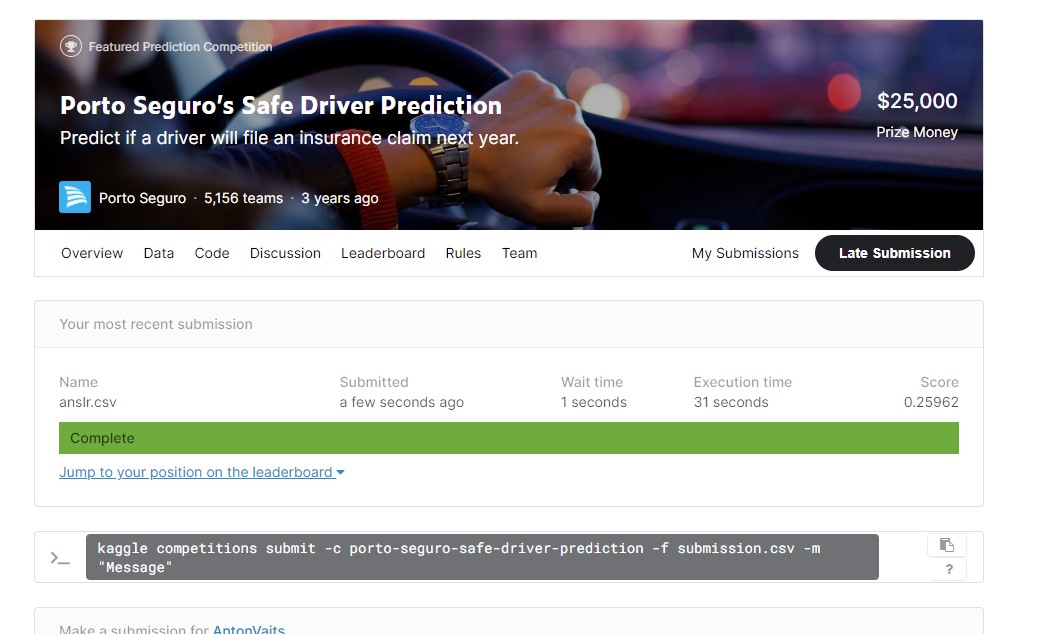